In [1]:
import os
import json

# Create the Kaggle API config directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the config directory
os.system("mv /kaggle/working/kaggle.json /root/.kaggle/")

# Change file permissions
os.system("chmod 600 /root/.kaggle/kaggle.json")

print("Kaggle API configured!")

Kaggle API configured!


# 1. Configuring Kaggle Api
For the datasets gotten from Kaggle, we need to configure Kaggle's Api and download and extract the datasets

In [2]:
import zipfile
import subprocess

datasets = {
    "novel_covid_xray": "subhankarsen/novel-covid19-chestxray-repository",
    "labeled_chest_xray": "tolgadincer/labeled-chest-xray-images",
    "pediatric_pneumonia_xray": "andrewmvd/pediatric-pneumonia-chest-xray"
}

base_path = "/kaggle/working/datasets"
os.makedirs(base_path, exist_ok=True)  # Ensure the directory exists

# Download and Extract
for name, kaggle_path in datasets.items():
    dataset_path = os.path.join(base_path, name)

    if os.path.exists(dataset_path) and os.listdir(dataset_path):
        print(f"Skipping {name} - already extracted.")
        continue  # If the dataset exists, skip to the next dataset

    print(f"Downloading {name}...")
    download_command = f"kaggle datasets download -d {kaggle_path} -p {base_path}"
    
    process = subprocess.run(download_command, shell=True, capture_output=True, text=True)
    
    if process.returncode != 0:
        print(f"Error downloading {name}: {process.stderr}")
        continue  # Skip to next dataset

    zip_path = os.path.join(base_path, f"{kaggle_path.split('/')[-1]}.zip")

    if os.path.exists(zip_path):  # Ensure the zip file exists before extracting
        print(f"Extracting {name}...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(dataset_path)

        os.remove(zip_path)  # Clean up the zip file after extraction
    else:
        print(f"Failed to download {name}. Check the dataset name or Kaggle credentials.")

print("All datasets checked and processed.")

Extracting novel_covid_xray...
Extracting labeled_chest_xray...
Extracting pediatric_pneumonia_xray...
All datasets checked and processed.


# **2. Imports**
Import necessary libraries for data processing, modeling, and evaluation.

In [3]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

import warnings
warnings.filterwarnings("ignore")

In [4]:
import cv2
import torch
import glob
import torch.nn as nn
import torch.optim as optim
import numpy as np
from skimage.util import random_noise
import pydicom
import random
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms.functional as TF

# **3. Data Preprocessing**
Load and preprocess X-ray images, including noise augmentation.

In [5]:
class XrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        #Gather all valid image paths
        self.image_paths = glob.glob(os.path.join(root_dir, "**", "*.*"), recursive=True)
        self.image_paths = [p for p in self.image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(self.image_paths) == 0:
            raise ValueError(f"No valid image found in {root_dir}")

    
    def __len__(self):
        return len(self.image_paths)

    
    def add_gaussian_poisson_noise(self, image):
        #Adds both noise to a greyscale image
        image = image.astype(np.float32)

        #Apply poisson noise
        poisson_scale = random.uniform(50, 300) #Vary the poisson noise per image
        photon_image = image/255.0 * poisson_scale
        noisy_poisson = np.random.poisson(photon_image)
        poisson_noise = (noisy_poisson/poisson_scale * 255.0)

        #Apply Gaussian noise
        gaussian_std = random.uniform(5,25)
        gaussian_noise = np.random.normal(0,gaussian_std, image.shape)

        #Combine both noises
        noisy_combined = poisson_noise + gaussian_noise
        noisy_combined = np.clip(noisy_combined, 0, 255)

        return noisy_combined.astype(np.uint8)

    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        try:
            image = Image.open(img_path).convert('L')
        except Exception as e:
            print (f"Error loading image {img_path}: {str(e)}")
            image = Image.new('L', (256, 256), 0) #Fallback on a black image
        
        #Resize all images to 256x256 before processing
        image = image.resize((256, 256))

        #Apply augmentation before adding noise
        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            angle = random.uniform(-15,15)
            image = TF.rotate(image,angle)
        brightness_factor = random.uniform(0.9, 1.1)
        contrast_factor = random.uniform(0.9, 1.1)
        image = TF.adjust_brightness(image, brightness_factor)
        image = TF.adjust_contrast(image, contrast_factor)

        #convert pil image to numpy for noise application
        image_np = np.array(image, dtype=np.float32)
        noisy_np = self.add_gaussian_poisson_noise(image_np)

        #Convert both images to pytorch tensors
        clean_tensor = TF.to_tensor(image)  # [0, 1]
        noisy_tensor = TF.to_tensor(Image.fromarray(noisy_np))  # [0, 1]

        return noisy_tensor, clean_tensor
        

In [6]:
# Set dataset path
root_dir = "/kaggle/working/datasets/"

# Load the dataset
dataset = XrayDataset(root_dir)

In [7]:
print(dataset[0])

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0196,  ..., 0.0000, 0.0431, 0.0000],
         [0.0118, 0.0000, 0.0118,  ..., 0.0000, 0.0039, 0.0431],
         ...,
         [0.0000, 0.0000, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0235, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0196]]]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]))


# Using 10 random images to iterate my model

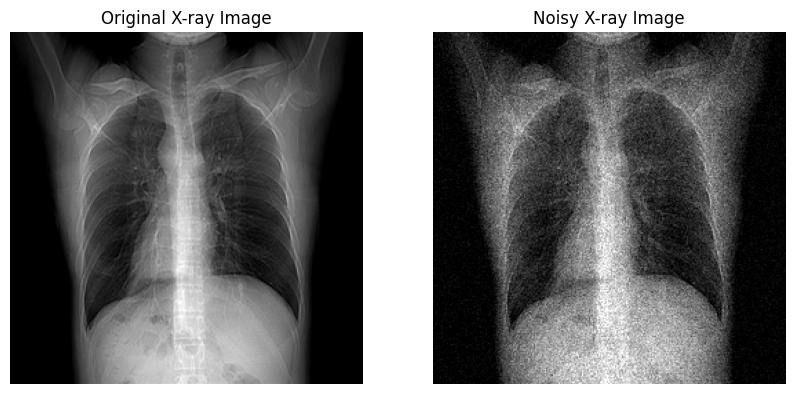

In [8]:
# Select 10 random images
# subset_size = 10
# random_indices = random.sample(range(len(dataset)), subset_size)
# dataset = Subset(dataset, random_indices)

# Load a sample image
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
sample_noisy, sample_clean = next(iter(dataloader))

# Convert tensors to numpy for visualization
sample_noisy_np = sample_noisy[0].squeeze().numpy()
sample_clean_np = sample_clean[0].squeeze().numpy()

# Plot original and noisy images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sample_clean_np, cmap='gray')
axes[0].set_title("Original X-ray Image")
axes[0].axis("off")

axes[1].imshow(sample_noisy_np, cmap='gray')
axes[1].set_title(f"Noisy X-ray Image")
axes[1].axis("off")

plt.show()

In [9]:
from torch.utils.data import random_split

# Total size
dataset_size = len(dataset)

# Split ratios (feel free to adjust)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Remaining

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False)

# **4. Model Architecture**
### **DnCNN Model** (Residual Learning for Noise Estimation)

In [10]:
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_layers=17):
        super(DnCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(channels, 64, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_layers-2):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(64, channels, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x-noise #Subtract the noise residual

In [11]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import pickle


def rmse_loss(pred, target):
    return torch.sqrt(nn.functional.mse_loss(pred, target))


def train_model(
    model,
    train_loader,
    val_loader=None,
    epochs=10,
    lr=1e-3,
    use_psnr_ssim=True,
    patience=5,
    save_path="best_model.pt",
    csv_path="metrics_log.csv",
    save_all_as_pkl=True,
    pkl_path="training_session.pkl",
):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    train_losses, val_losses = [], []
    val_psnr_scores, val_ssim_scores = [], []

    best_val_score = float("inf")  # RMSE baseline
    best_model_state = None
    epochs_without_improvement = 0

    csv_file = open(csv_path, mode='w', newline='')
    csv_writer = csv.writer(csv_file)
    headers = ["Epoch", "Train_RMSE", "Val_RMSE", "Val_PSNR", "Val_SSIM"]
    csv_writer.writerow(headers)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for noisy_imgs, clean_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            optimizer.zero_grad()
            outputs = model(noisy_imgs)
            loss = rmse_loss(outputs, clean_imgs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} | Train RMSE: {avg_train_loss:.4f}")

        # -------------------------
        # Validation
        # -------------------------
        if val_loader:
            model.eval()
            val_loss = 0.0
            total_psnr = 0.0
            total_ssim = 0.0

            with torch.no_grad():
                for noisy_imgs, clean_imgs in val_loader:
                    noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                    outputs = model(noisy_imgs)
                    loss = rmse_loss(outputs, clean_imgs)
                    val_loss += loss.item()

                    if use_psnr_ssim:
                        preds_np = outputs.squeeze(1).cpu().numpy()
                        targets_np = clean_imgs.squeeze(1).cpu().numpy()
                        for i in range(preds_np.shape[0]):
                            total_psnr += psnr(targets_np[i], preds_np[i], data_range=1.0)
                            total_ssim += ssim(targets_np[i], preds_np[i], data_range=1.0)

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            if use_psnr_ssim:
                num_val_imgs = len(val_loader.dataset)
                avg_psnr = total_psnr / num_val_imgs
                avg_ssim = total_ssim / num_val_imgs
                val_psnr_scores.append(avg_psnr)
                val_ssim_scores.append(avg_ssim)
                print(f"→ Val RMSE: {avg_val_loss:.4f}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")
            else:
                avg_psnr, avg_ssim = None, None
                print(f"→ Val RMSE: {avg_val_loss:.4f}")

            # Write to CSV
            csv_writer.writerow([epoch + 1, avg_train_loss, avg_val_loss, avg_psnr, avg_ssim])

            # -------------------------
            # Save Best Model (Based on RMSE)
            # -------------------------
            if avg_val_loss < best_val_score:
                best_val_score = avg_val_loss
                best_model_state = model.state_dict()
                torch.save(best_model_state, save_path)
                print("✅ Best model saved!")
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                print(f"No improvement. Patience counter: {epochs_without_improvement}/{patience}")

            # -------------------------
            # Early Stopping
            # -------------------------
            if epochs_without_improvement >= patience:
                print("⏹️ Early stopping triggered.")
                break

    csv_file.close()

    # -------------------------
    # Save all metrics and configs
    # -------------------------
    if save_all_as_pkl:
        training_data = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_psnr": val_psnr_scores,
            "val_ssim": val_ssim_scores,
            "best_model_path": save_path,
            "csv_path": csv_path,
            "best_val_rmse": best_val_score,
        }
        with open(pkl_path, "wb") as f:
            pickle.dump(training_data, f)
        print(f"📦 Session saved as {pkl_path}")

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train RMSE")
    if val_loader:
        plt.plot(val_losses, label="Val RMSE")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot PSNR/SSIM if enabled
    if use_psnr_ssim and val_psnr_scores:
        plt.figure(figsize=(10, 5))
        plt.plot(val_psnr_scores, label="Val PSNR")
        plt.plot(val_ssim_scores, label="Val SSIM")
        plt.xlabel("Epoch")
        plt.title("Validation Image Quality Metrics")
        plt.legend()
        plt.grid(True)
        plt.show()

    return model

In [12]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def evaluate_model(model, dataloader, compute_psnr_ssim=True, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    model.to(device)

    rmse_loss = torch.nn.MSELoss(reduction='mean')
    total_rmse, total_psnr, total_ssim = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(dataloader, desc="Evaluating"):
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)

            outputs = model(noisy_imgs)

            # RMSE
            mse = rmse_loss(outputs, clean_imgs).item()
            rmse = mse ** 0.5
            total_rmse += rmse

            # PSNR & SSIM
            if compute_psnr_ssim:
                preds_np = outputs.squeeze(1).cpu().numpy()
                targets_np = clean_imgs.squeeze(1).cpu().numpy()

                for i in range(preds_np.shape[0]):
                    total_psnr += psnr(targets_np[i], preds_np[i], data_range=1.0)
                    total_ssim += ssim(targets_np[i], preds_np[i], data_range=1.0)

            count += noisy_imgs.size(0)

    avg_rmse = total_rmse / count
    avg_psnr = total_psnr / count if compute_psnr_ssim else None
    avg_ssim = total_ssim / count if compute_psnr_ssim else None

    print("\n📊 Final Evaluation:")
    print(f"→ RMSE: {avg_rmse:.4f}")
    if compute_psnr_ssim:
        print(f"→ PSNR: {avg_psnr:.2f}")
        print(f"→ SSIM: {avg_ssim:.4f}")

    return {
        "rmse": avg_rmse,
        "psnr": avg_psnr,
        "ssim": avg_ssim
    }

Epoch 1/10: 100%|██████████| 2745/2745 [16:43<00:00,  2.74it/s]


Epoch 1 | Train RMSE: 0.0311
→ Val RMSE: 0.0256, PSNR: 32.06, SSIM: 0.8200
✅ Best model saved!


Epoch 2/10: 100%|██████████| 2745/2745 [16:42<00:00,  2.74it/s]


Epoch 2 | Train RMSE: 0.0239
→ Val RMSE: 0.0230, PSNR: 33.00, SSIM: 0.8665
✅ Best model saved!


Epoch 3/10: 100%|██████████| 2745/2745 [16:37<00:00,  2.75it/s]


Epoch 3 | Train RMSE: 0.0229
→ Val RMSE: 0.0238, PSNR: 32.67, SSIM: 0.8204
No improvement. Patience counter: 1/5


Epoch 4/10: 100%|██████████| 2745/2745 [16:35<00:00,  2.76it/s]


Epoch 4 | Train RMSE: 0.0224
→ Val RMSE: 0.0218, PSNR: 33.48, SSIM: 0.8825
✅ Best model saved!


Epoch 5/10: 100%|██████████| 2745/2745 [16:36<00:00,  2.75it/s]


Epoch 5 | Train RMSE: 0.0219
→ Val RMSE: 0.0213, PSNR: 33.68, SSIM: 0.8875
✅ Best model saved!


Epoch 6/10: 100%|██████████| 2745/2745 [16:34<00:00,  2.76it/s]


Epoch 6 | Train RMSE: 0.0216
→ Val RMSE: 0.0211, PSNR: 33.74, SSIM: 0.8897
✅ Best model saved!


Epoch 7/10: 100%|██████████| 2745/2745 [16:33<00:00,  2.76it/s]


Epoch 7 | Train RMSE: 0.0213
→ Val RMSE: 0.0212, PSNR: 33.72, SSIM: 0.8875
No improvement. Patience counter: 1/5


Epoch 8/10: 100%|██████████| 2745/2745 [16:31<00:00,  2.77it/s]


Epoch 8 | Train RMSE: 0.0212
→ Val RMSE: 0.0217, PSNR: 33.48, SSIM: 0.8683
No improvement. Patience counter: 2/5


Epoch 9/10: 100%|██████████| 2745/2745 [16:31<00:00,  2.77it/s]


Epoch 9 | Train RMSE: 0.0210
→ Val RMSE: 0.0211, PSNR: 33.75, SSIM: 0.8732
✅ Best model saved!


Epoch 10/10: 100%|██████████| 2745/2745 [16:39<00:00,  2.75it/s]


Epoch 10 | Train RMSE: 0.0209
→ Val RMSE: 0.0207, PSNR: 33.90, SSIM: 0.8870
✅ Best model saved!
📦 Session saved as denoising_training.pkl


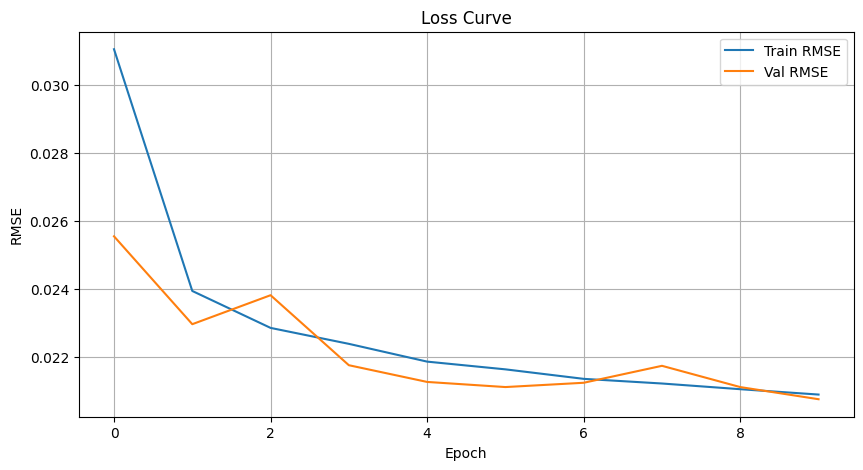

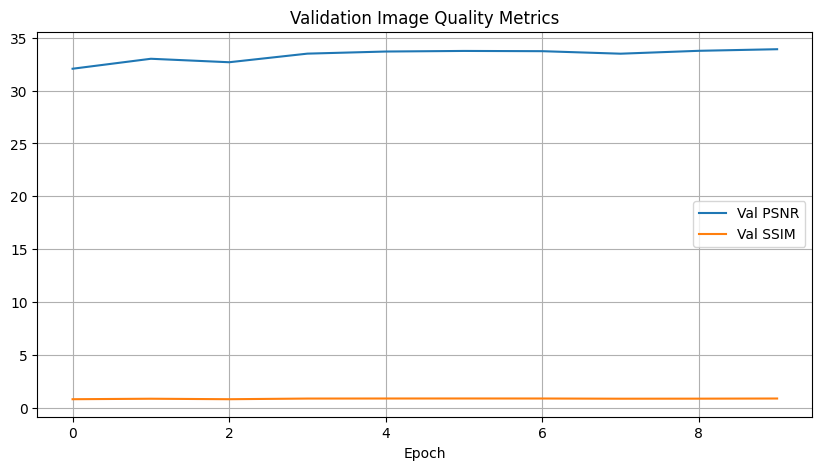

Evaluating: 100%|██████████| 589/589 [01:46<00:00,  5.51it/s]


📊 Final Evaluation:
→ RMSE: 0.0051
→ PSNR: 33.97
→ SSIM: 0.8880


{'rmse': 0.005145705829823305,
 'psnr': 33.97252121582192,
 'ssim': 0.8879590310926636}

In [13]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize and Train Model
model =DnCNN().to(device)
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=1e-4,
    patience=5,
    save_path="best_denoiser.pt",
    csv_path="denoising_metrics.csv",
    pkl_path="denoising_training.pkl"
)

# Evaluate Model
evaluate_model(trained_model, test_loader)